In [28]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [29]:
df = pd.read_json("exps.jsonl", lines=True)
print(len(df))
df.head()

10


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,698469ea608e3359e23ca7295849e0aca721737e,riant-duad,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0,cok/adapted.txt,cq.txt,semi/cok.json,...,161,863,82.475087,23.488537,3,67.0,81,96.5,168,COK
1,f6a11e56b2290d8503564757de7bc95211f249c8,lairy-weka,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0,ccot/format-thought.txt,cq.txt,semi/ccot.json,...,103,2292,16.564136,191.058127,0,0.0,0,4.0,5120,CCOT
2,9ccb840e02fb17eddf61deccfe0a6db45a63c40c,lowly-mesh,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0,cot/format-thought.txt,cq.txt,semi/cot.json,...,162,768,61.272135,21.961152,6,46.0,58,72.0,140,COT
3,1e4c71b1585d18d4a14578e66d14be874ad78ef2,model-wire,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0,cte/format-triplets-few.txt,cq.txt,semi/cte.json,...,91,746,48.310992,16.961933,16,37.0,45,56.0,153,CTE
4,00ca4c1383ea6b9b0921e4616fac5b073984a363,heady-yews,bdsaglam/musique,answerable,validation,llama-3-70b-tgi,0,direct/format-few.txt,cq.txt,semi/direct.json,...,26,690,7.726087,9.269645,3,4.0,5,7.0,89,DIRECT


In [30]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [31]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.n_shot",
    "params.qa.n_sc",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)
df.head()

,name,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.n_sc,params.run,metrics.exact_match,metrics.f1,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,adust-paws,0,ccot/format-thought.txt,cq.txt,semi/ccot.json,0,1,1,0.591643,0.710493,...,162,700,49.575714,17.156312,19,38.00,47,59.0,187,CCOT
1,lairy-weka,0,ccot/format-thought.txt,cq.txt,semi/ccot.json,3,1,1,0.036409,0.052465,...,103,2292,16.564136,191.058127,0,0.00,0,4.0,5120,CCOT
2,gypsy-feel,0,cok/adapted.txt,cq.txt,semi/cok.json,0,1,1,0.612329,0.725410,...,243,674,102.606825,35.052430,24,78.00,97,118.0,300,COK
3,riant-duad,0,cok/adapted.txt,cq.txt,semi/cok.json,3,1,1,0.547373,0.656394,...,161,863,82.475087,23.488537,3,67.00,81,96.5,168,COK
4,laigh-flex,0,cot/format-thought.txt,cq.txt,semi/cot.json,0,1,1,0.584195,0.706219,...,211,712,65.831461,92.391326,16,46.75,58,72.0,2444,COT


In [32]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) != 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.n_sc,params.qa.temperature,params.run
0,CCOT,ccot/format-thought.txt,cq.txt,semi/ccot.json,0,1,0,"(1,)"
1,CCOT,ccot/format-thought.txt,cq.txt,semi/ccot.json,3,1,0,"(1,)"
2,COK,cok/adapted.txt,cq.txt,semi/cok.json,0,1,0,"(1,)"
3,COK,cok/adapted.txt,cq.txt,semi/cok.json,3,1,0,"(1,)"
4,COT,cot/format-thought.txt,cq.txt,semi/cot.json,0,1,0,"(1,)"
5,COT,cot/format-thought.txt,cq.txt,semi/cot.json,3,1,0,"(1,)"
6,CTE,cte/format-triplets-few.txt,cq.txt,semi/cte.json,0,1,0,"(1,)"
7,CTE,cte/format-triplets-few.txt,cq.txt,semi/cte.json,3,1,0,"(1,)"
8,DIRECT,direct/format-few.txt,cq.txt,semi/direct.json,0,1,0,"(1,)"
9,DIRECT,direct/format-few.txt,cq.txt,semi/direct.json,3,1,0,"(1,)"


In [33]:
def remove_ext(filename):
    return filename.split(".", 1)[0]


for col in [
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
]:
    df[col] = df[col].map(remove_ext)

In [55]:
avg_df = df.groupby(target_param_cols)[metric_cols].max().reset_index()
avg_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.n_sc,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,...,metrics.gen_token_count.success.75%,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max
0,CCOT,ccot/format-thought,cq,semi/ccot,0,1,0,0.591643,0.710493,0.627796,...,52,162,700,49.575714,17.156312,19,38.00,47,59.0,187
1,CCOT,ccot/format-thought,cq,semi/ccot,3,1,0,0.036409,0.052465,0.000000,...,55,103,2292,16.564136,191.058127,0,0.00,0,4.0,5120
2,COK,cok/adapted,cq,semi/cok,0,1,0,0.612329,0.725410,0.651757,...,112,243,674,102.606825,35.052430,24,78.00,97,118.0,300
3,COK,cok/adapted,cq,semi/cok,3,1,0,0.547373,0.656394,0.555911,...,94,161,863,82.475087,23.488537,3,67.00,81,96.5,168
4,COT,cot/format-thought,cq,semi/cot,0,1,0,0.584195,0.706219,0.617412,...,65,211,712,65.831461,92.391326,16,46.75,58,72.0,2444
5,COT,cot/format-thought,cq,semi/cot,3,1,0,0.573024,0.689830,0.624601,...,62,162,768,61.272135,21.961152,6,46.00,58,72.0,140
6,CTE,cte/format-triplets-few,cq,semi/cte,0,1,0,0.590401,0.709570,0.615016,...,54,177,697,45.964132,23.595919,7,33.00,43,56.0,263
7,CTE,cte/format-triplets-few,cq,semi/cte,3,1,0,0.582954,0.702151,0.619010,...,50,91,746,48.310992,16.961933,16,37.00,45,56.0,153
8,DIRECT,direct/format-few,cq,semi/direct,0,1,0,0.291684,0.366754,0.444089,...,8,105,1560,50.284615,44.330988,3,22.00,43,65.0,878
9,DIRECT,direct/format-few,cq,semi/direct,3,1,0,0.603227,0.719669,0.648562,...,7,26,690,7.726087,9.269645,3,4.00,5,7.0,89


In [35]:
# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)
best_df

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.n_sc,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,...,metrics.gen_token_count.success.75%,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max
2,COK,cok/adapted,cq,semi/cok,0,1,0,0.612329,0.725410,0.651757,...,112,243,674,102.606825,35.052430,24,78.00,97,118.0,300
9,DIRECT,direct/format-few,cq,semi/direct,3,1,0,0.603227,0.719669,0.648562,...,7,26,690,7.726087,9.269645,3,4.00,5,7.0,89
0,CCOT,ccot/format-thought,cq,semi/ccot,0,1,0,0.591643,0.710493,0.627796,...,52,162,700,49.575714,17.156312,19,38.00,47,59.0,187
6,CTE,cte/format-triplets-few,cq,semi/cte,0,1,0,0.590401,0.709570,0.615016,...,54,177,697,45.964132,23.595919,7,33.00,43,56.0,263
4,COT,cot/format-thought,cq,semi/cot,0,1,0,0.584195,0.706219,0.617412,...,65,211,712,65.831461,92.391326,16,46.75,58,72.0,2444


In [56]:
avg_df[avg_df['params.qa.n_shot']==0]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.n_sc,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,...,metrics.gen_token_count.success.75%,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max
0,CCOT,ccot/format-thought,cq,semi/ccot,0,1,0,0.591643,0.710493,0.627796,...,52,162,700,49.575714,17.156312,19,38.00,47,59.0,187
2,COK,cok/adapted,cq,semi/cok,0,1,0,0.612329,0.725410,0.651757,...,112,243,674,102.606825,35.052430,24,78.00,97,118.0,300
4,COT,cot/format-thought,cq,semi/cot,0,1,0,0.584195,0.706219,0.617412,...,65,211,712,65.831461,92.391326,16,46.75,58,72.0,2444
6,CTE,cte/format-triplets-few,cq,semi/cte,0,1,0,0.590401,0.709570,0.615016,...,54,177,697,45.964132,23.595919,7,33.00,43,56.0,263
8,DIRECT,direct/format-few,cq,semi/direct,0,1,0,0.291684,0.366754,0.444089,...,8,105,1560,50.284615,44.330988,3,22.00,43,65.0,878


## Visualizations

In [36]:
def prepare_data(dataf):
    # Simplify column names for use in formula
    dataf = dataf[target_param_cols + ['params.run'] + metric_cols[:2]].rename(
        columns={
            col: col.replace("params.qa.", "").replace("params.", "").replace("metrics.", "")
            for col in dataf.columns
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt_template"]
        + " | "
        + dataf["n_shot"].map(str)
    )

    return dataf


In [37]:
def plot_variance(dataf, x='temperature', y='f1', hue='prompt', technique=None, figsize=(12, 8), legend='auto', legend_loc='lower left'):  
    if technique:
        dataf = dataf[dataf['technique'] == technique]
    plt.figure(figsize=figsize)
    sns.lineplot(x=x, y=y, hue=hue, data=dataf, linewidth=2.5, legend=legend)
    plt.xlabel(x.title())
    plt.ylabel(y.title())
    if legend:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

In [38]:
def plot_variance_grid(dataf, x='temperature', y='f1', hue='prompt', figsize=(6, 4), legend='auto', legend_loc='lower left'):
    techniques = dataf['technique'].unique()
    n = len(techniques)
    n_cols = 2
    n_rows = (n + 1) // n_cols  # Calculate the number of rows needed for nx2 grid
    figsize = (figsize[0] * n_cols, figsize[1] * n_rows)  # Adjust the figure size based on the number of rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, technique in enumerate(techniques):
        ax = axes[i]
        subset = dataf[dataf['technique'] == technique]
        sns.lineplot(x=x, y=y, hue=hue, data=subset, linewidth=2.5, legend=False, ax=ax)
        ax.set_title(technique)
        ax.set_xlabel(x.title())
        ax.set_ylabel(y.title())

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [39]:
prepared_df = prepare_data(df)
zero_shot_mask = prepared_df["n_shot"] == 0
prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,n_sc,temperature,run,exact_match,f1,prompt
0,CCOT,ccot/format-thought,cq,semi/ccot,0,1,0,1,0.591643,0.710493,ccot/format-thought | cq | 0
1,CCOT,ccot/format-thought,cq,semi/ccot,3,1,0,1,0.036409,0.052465,ccot/format-thought | cq | 3
2,COK,cok/adapted,cq,semi/cok,0,1,0,1,0.612329,0.725410,cok/adapted | cq | 0
3,COK,cok/adapted,cq,semi/cok,3,1,0,1,0.547373,0.656394,cok/adapted | cq | 3
4,COT,cot/format-thought,cq,semi/cot,0,1,0,1,0.584195,0.706219,cot/format-thought | cq | 0
5,COT,cot/format-thought,cq,semi/cot,3,1,0,1,0.573024,0.689830,cot/format-thought | cq | 3
6,CTE,cte/format-triplets-few,cq,semi/cte,0,1,0,1,0.590401,0.709570,cte/format-triplets-few | cq | 0
7,CTE,cte/format-triplets-few,cq,semi/cte,3,1,0,1,0.582954,0.702151,cte/format-triplets-few | cq | 3
8,DIRECT,direct/format-few,cq,semi/direct,0,1,0,1,0.291684,0.366754,direct/format-few | cq | 0
9,DIRECT,direct/format-few,cq,semi/direct,3,1,0,1,0.603227,0.719669,direct/format-few | cq | 3


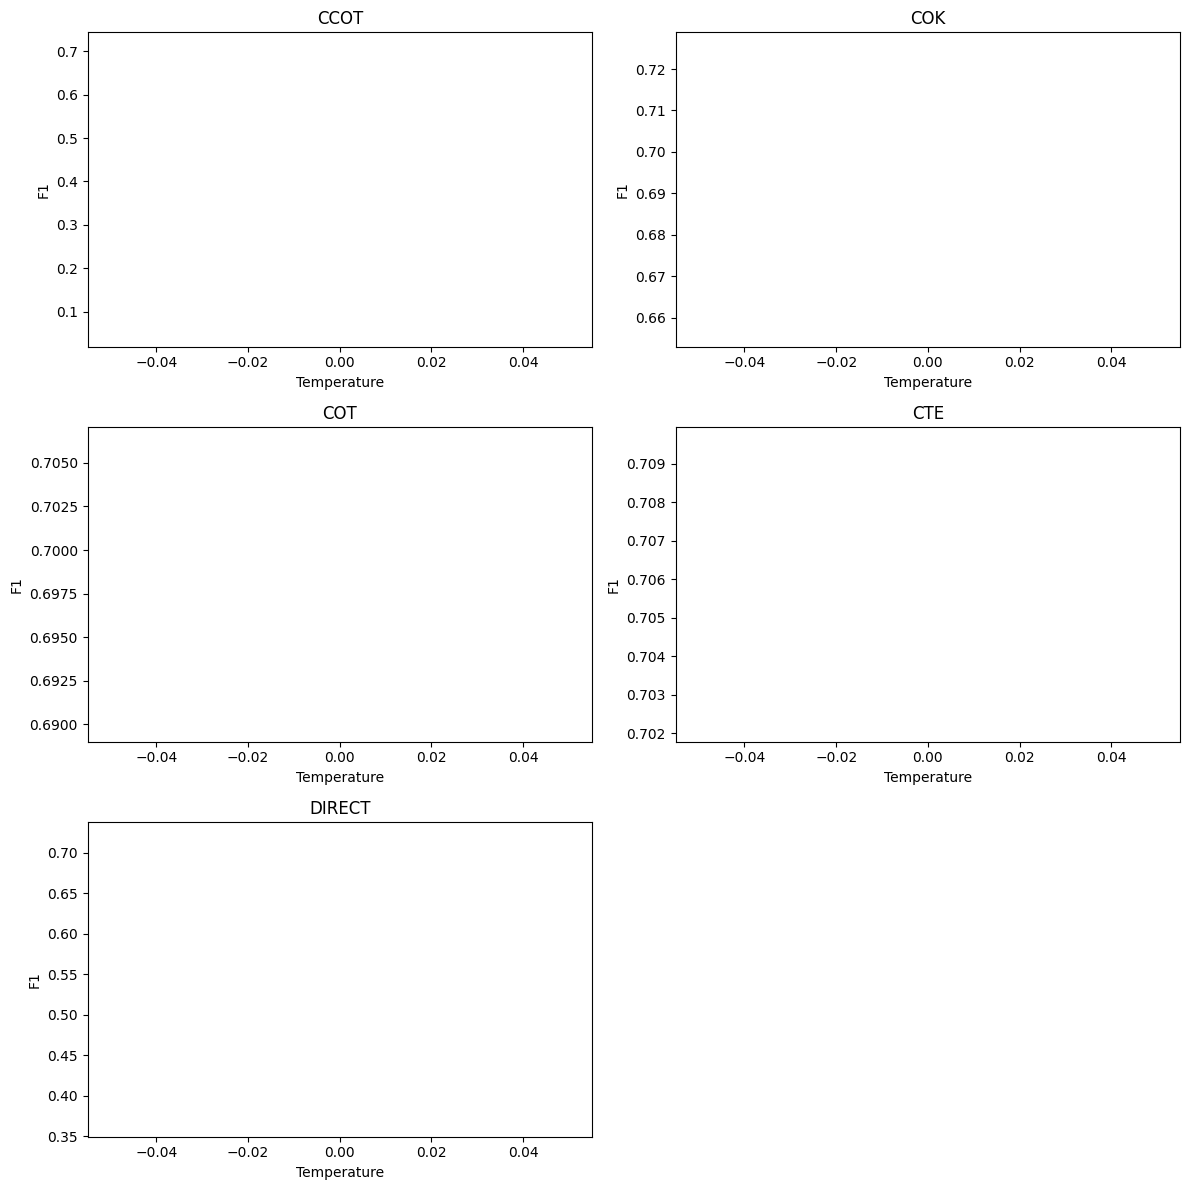

In [40]:
plot_variance_grid(prepared_df, x='temperature', y='f1', hue='prompt', legend_loc='upper left')

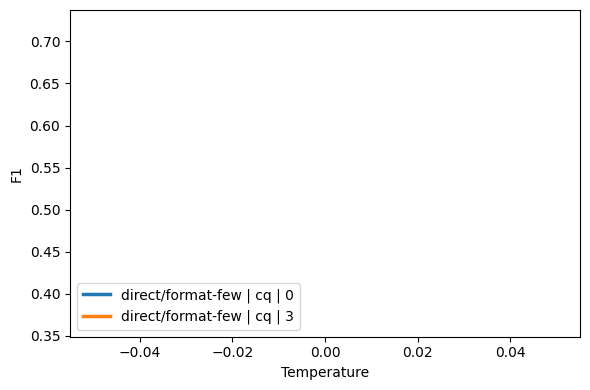

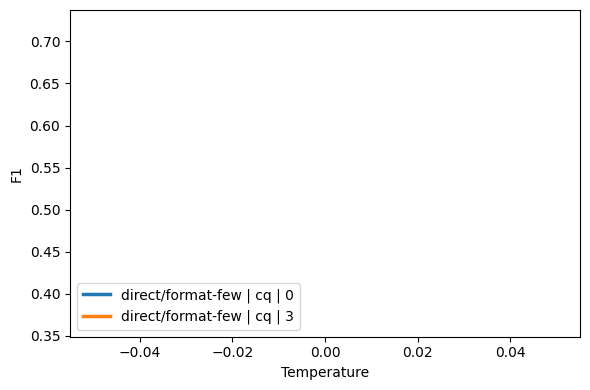

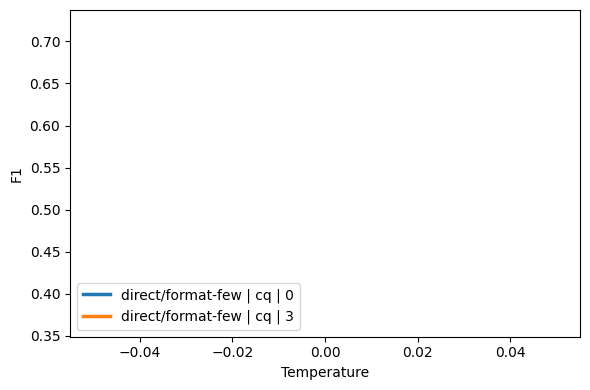

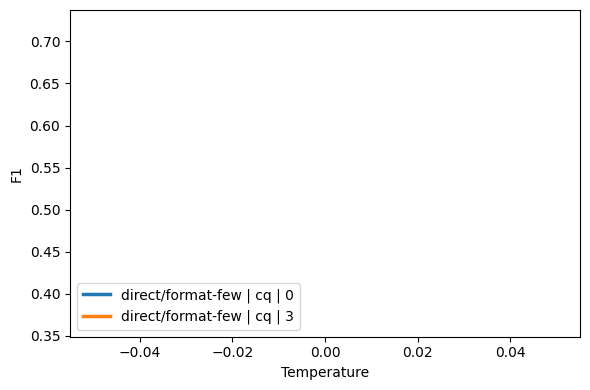

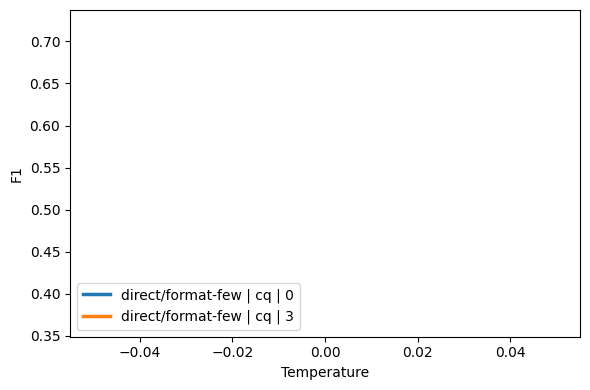

In [41]:
for technique in prepared_df['technique'].unique():
    plot_variance(prepared_df, technique='DIRECT', legend='brief', figsize=(6, 4))

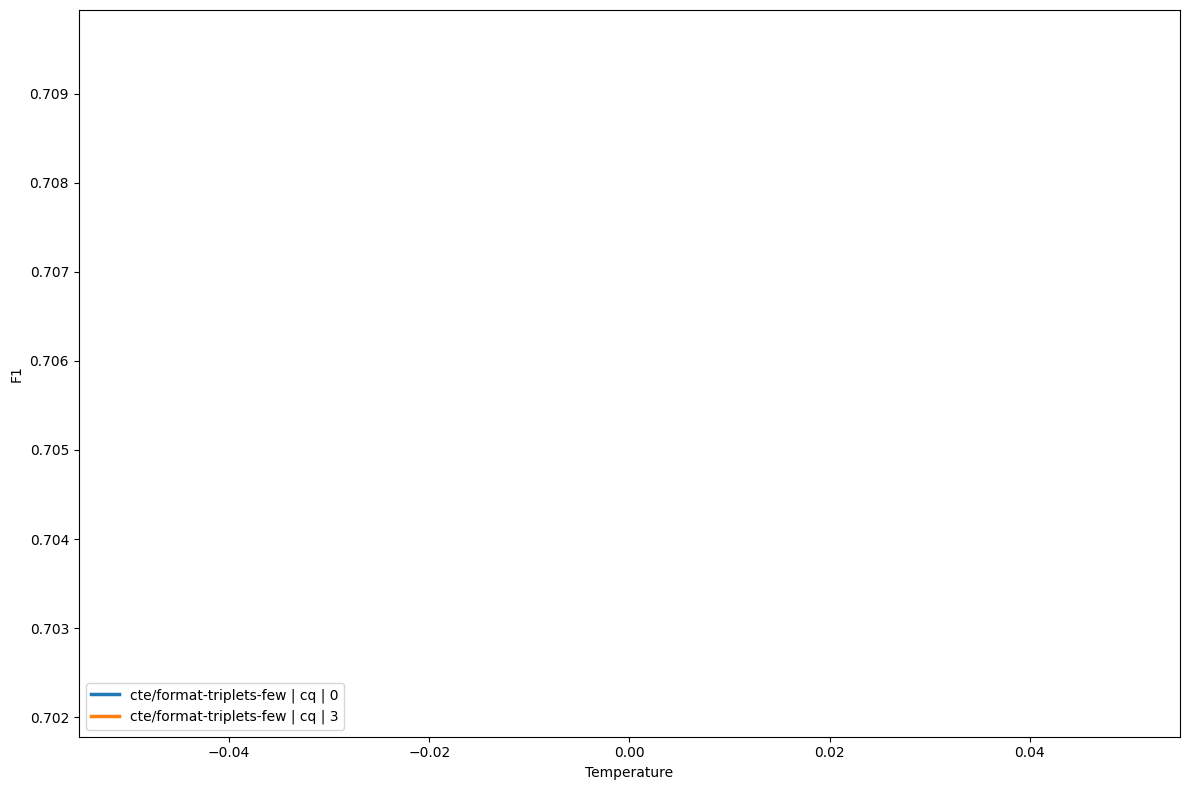

In [42]:
plot_variance(prepared_df, technique='CTE', legend='brief')

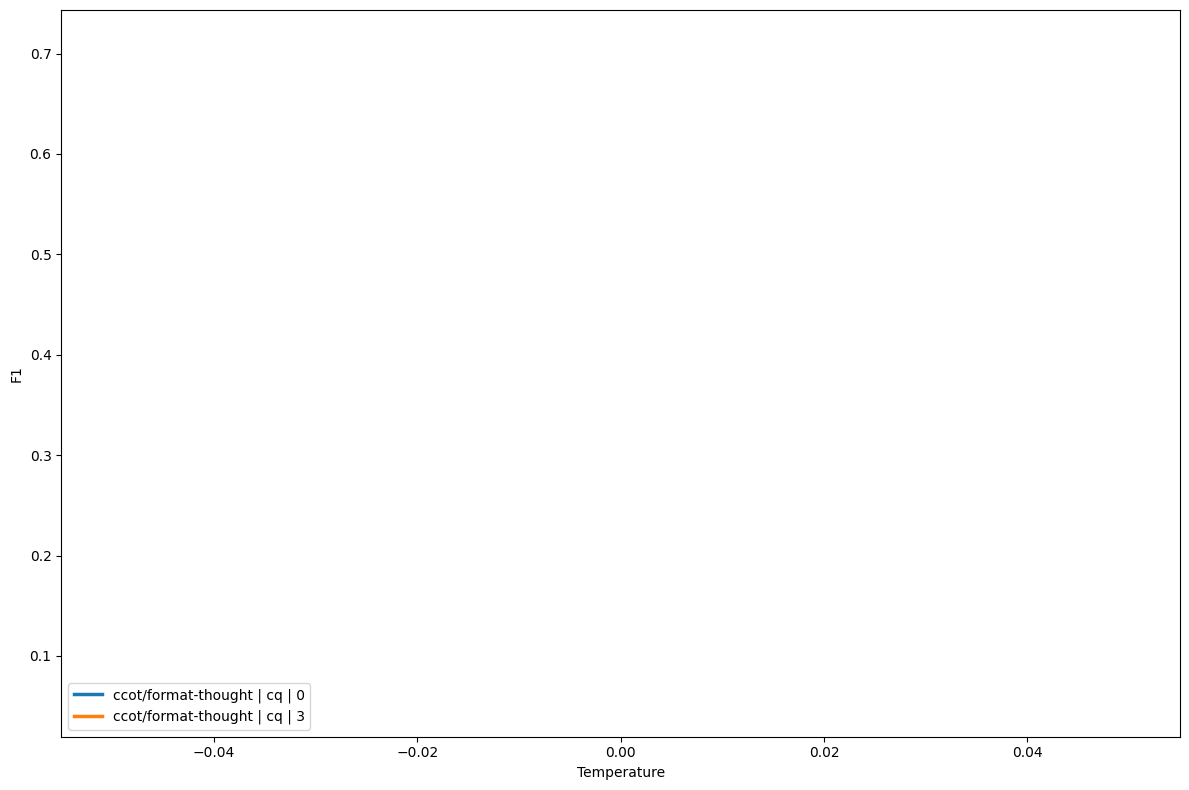

In [43]:
plot_variance(prepared_df, technique='CCOT', legend='brief')

In [44]:
best_df['params.run'] = 0
best_prompts = prepare_data(best_df).prompt.values.tolist()
_data = prepared_df.copy()
prompt_mask = _data['prompt'].isin(best_prompts)
best_prepared_df = _data.loc[prompt_mask]
best_prepared_df

,technique,system_prompt,user_prompt_template,few_shot_examples,n_shot,n_sc,temperature,run,exact_match,f1,prompt
0,CCOT,ccot/format-thought,cq,semi/ccot,0,1,0,1,0.591643,0.710493,ccot/format-thought | cq | 0
2,COK,cok/adapted,cq,semi/cok,0,1,0,1,0.612329,0.725410,cok/adapted | cq | 0
4,COT,cot/format-thought,cq,semi/cot,0,1,0,1,0.584195,0.706219,cot/format-thought | cq | 0
6,CTE,cte/format-triplets-few,cq,semi/cte,0,1,0,1,0.590401,0.709570,cte/format-triplets-few | cq | 0
9,DIRECT,direct/format-few,cq,semi/direct,3,1,0,1,0.603227,0.719669,direct/format-few | cq | 3


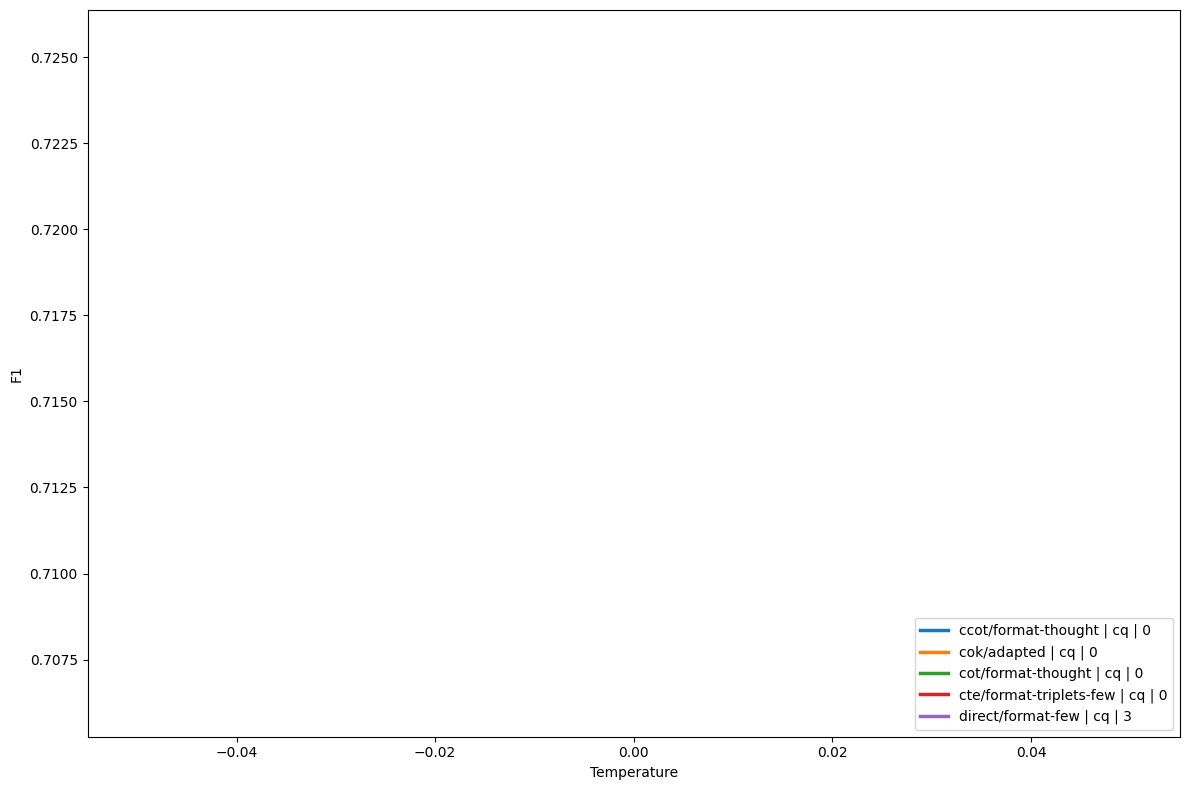

In [45]:
plot_variance(best_prepared_df, figsize=(12, 8), legend_loc='lower right')

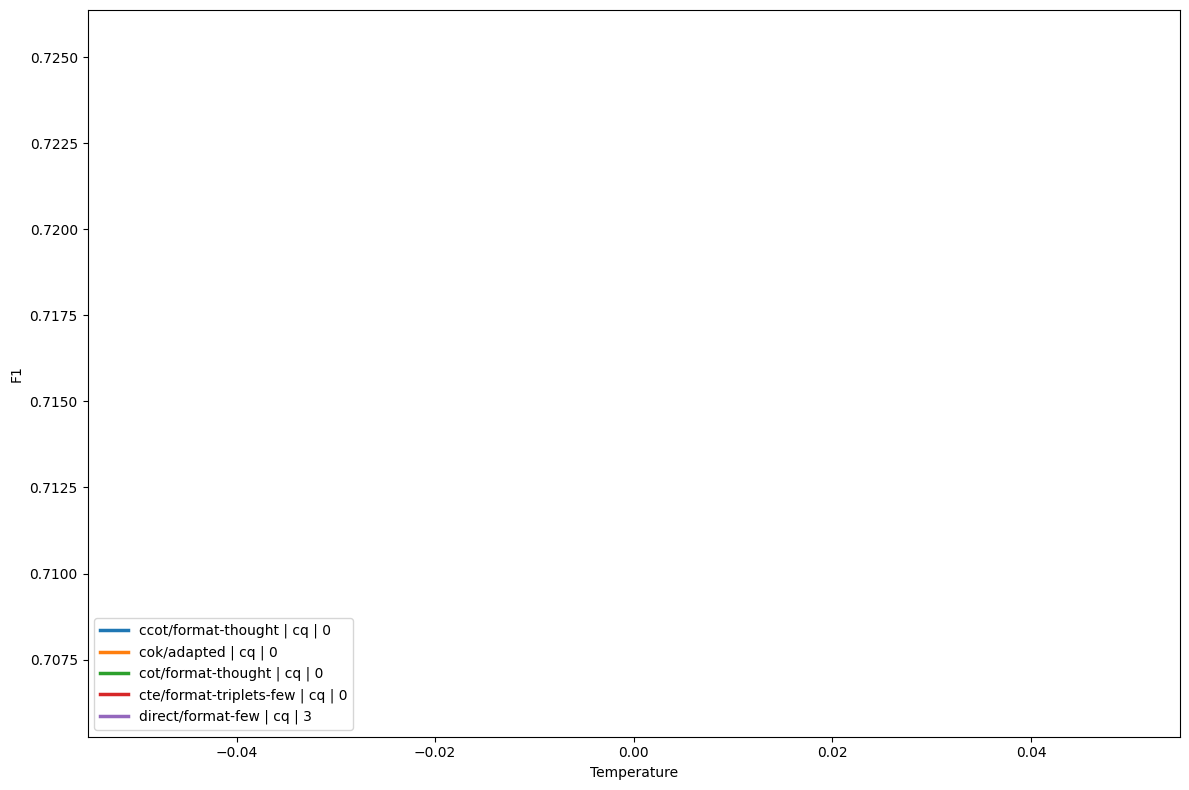

In [46]:
plot_variance(best_prepared_df, figsize=(12, 8), legend_loc='lower left')

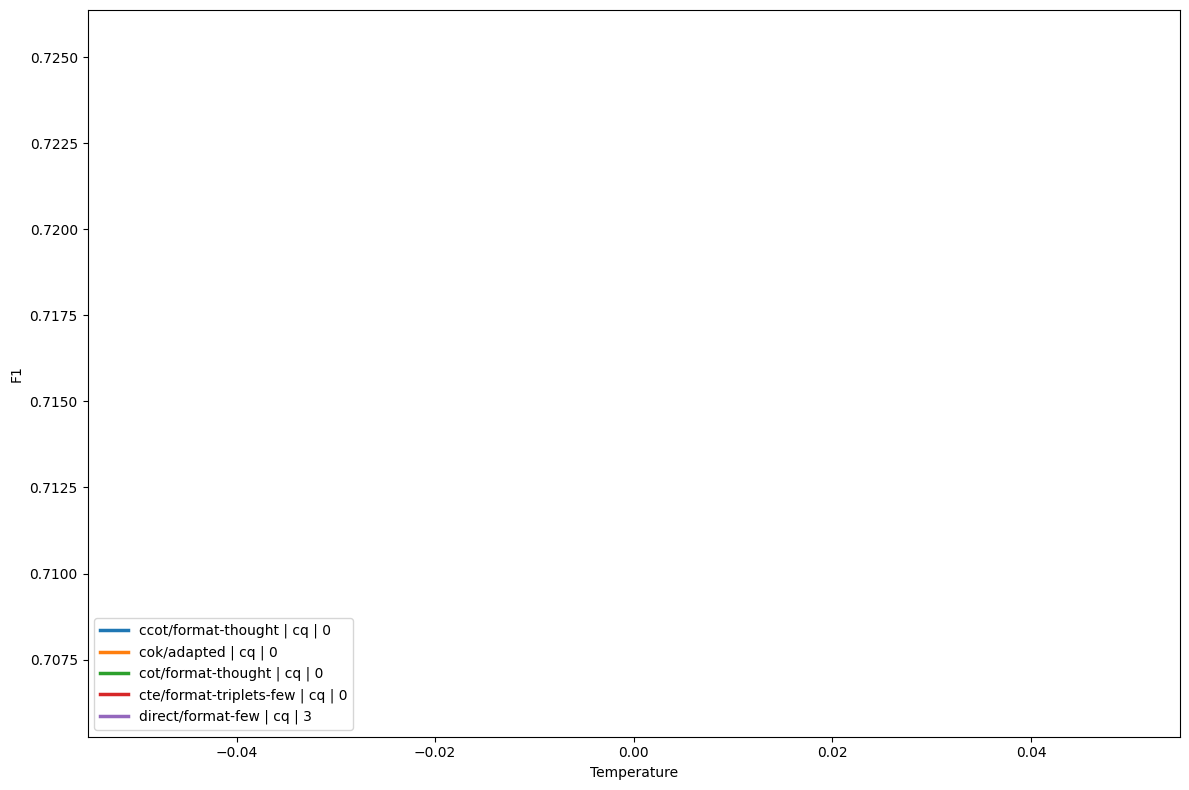

In [47]:
plot_variance(best_prepared_df[best_prepared_df['temperature'] <= 1.0], figsize=(12, 8), legend_loc='lower left')

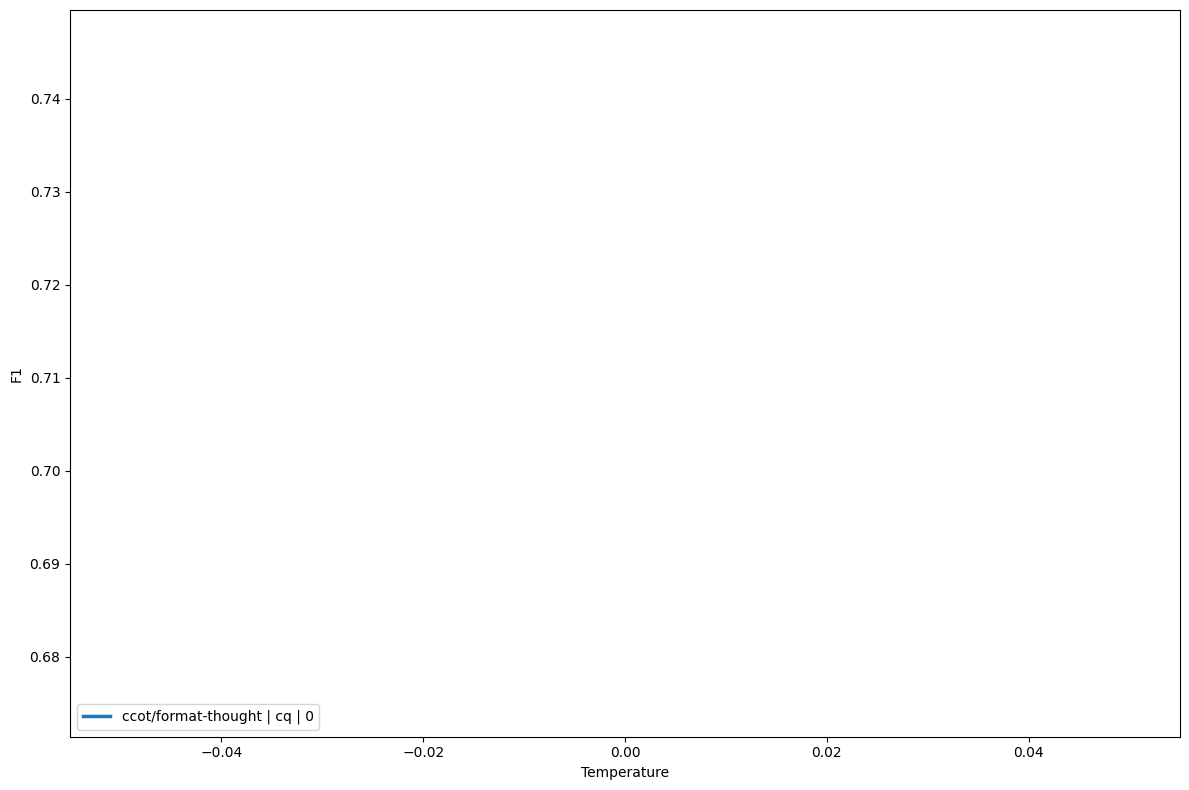

In [48]:
plot_variance(best_prepared_df[best_prepared_df['temperature'] <= 1.0], technique='CCOT', figsize=(12, 8), legend_loc='lower left')

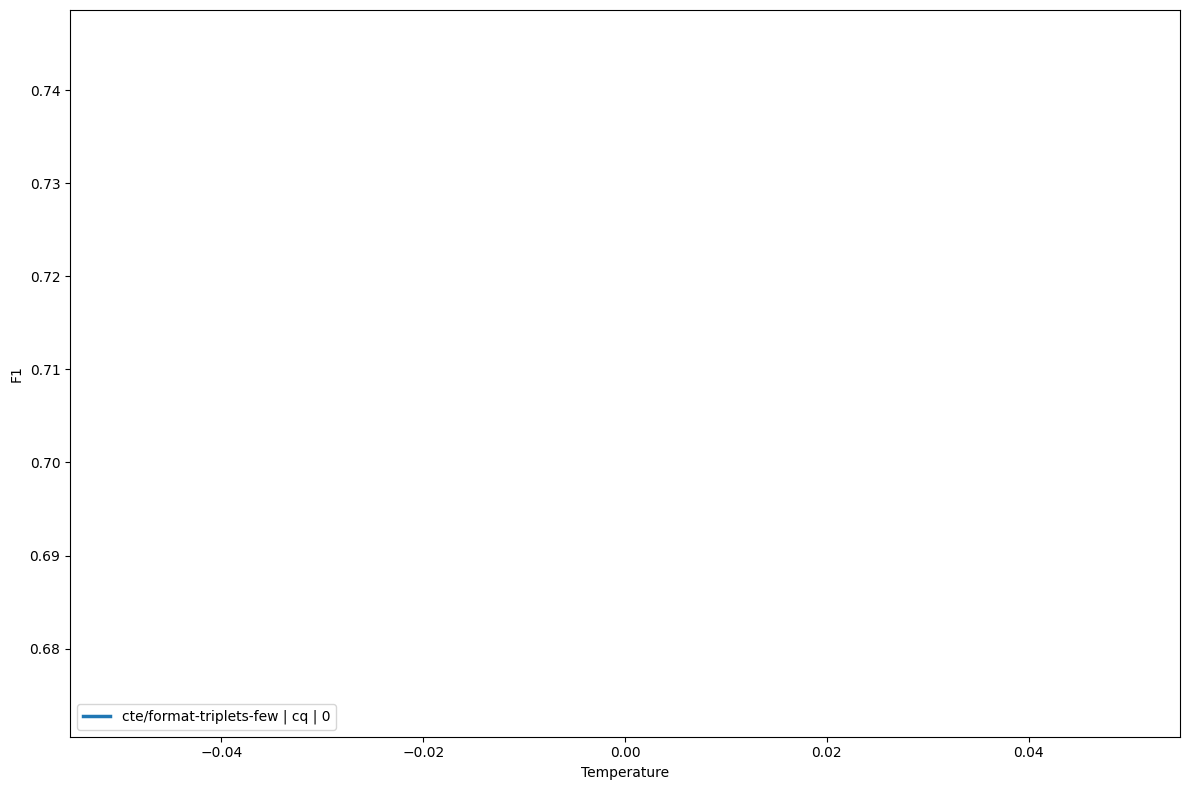

In [49]:
plot_variance(best_prepared_df[best_prepared_df['temperature'] <= 1.0], technique='CTE', figsize=(12, 8), legend_loc='lower left')

## Inspect

In [50]:
# # box-whisker plot
# plt.figure(figsize=(12, 8))
# sns.boxplot(
#     x="prompt",
#     y="f1",
#     data=prepared_df.sort_values(by="f1"),
# )
# plt.xticks(rotation=60, ha="right");

/tmp/ipykernel_2922816/1818533546.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=legend_loc)


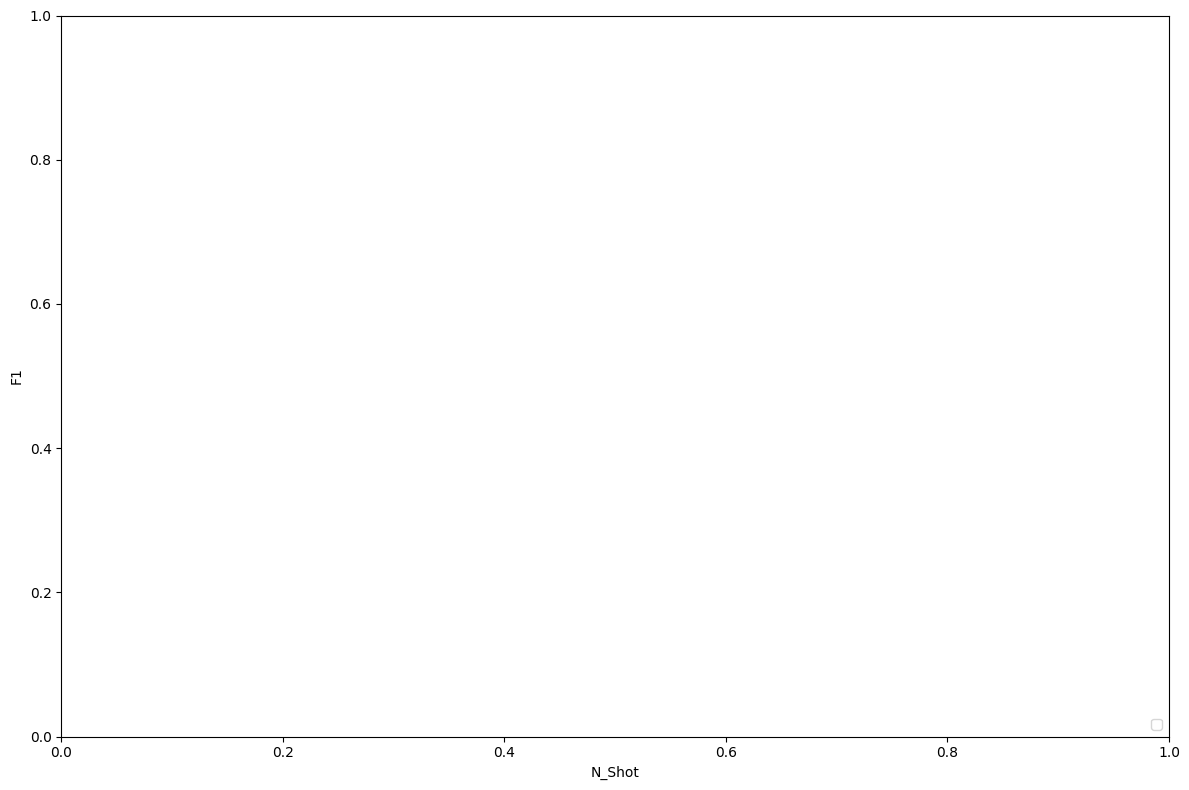

In [51]:
plot_variance(prepared_df[prepared_df['temperature'] == 0.1], x='n_shot', hue='technique', figsize=(12, 8), legend_loc='lower right')

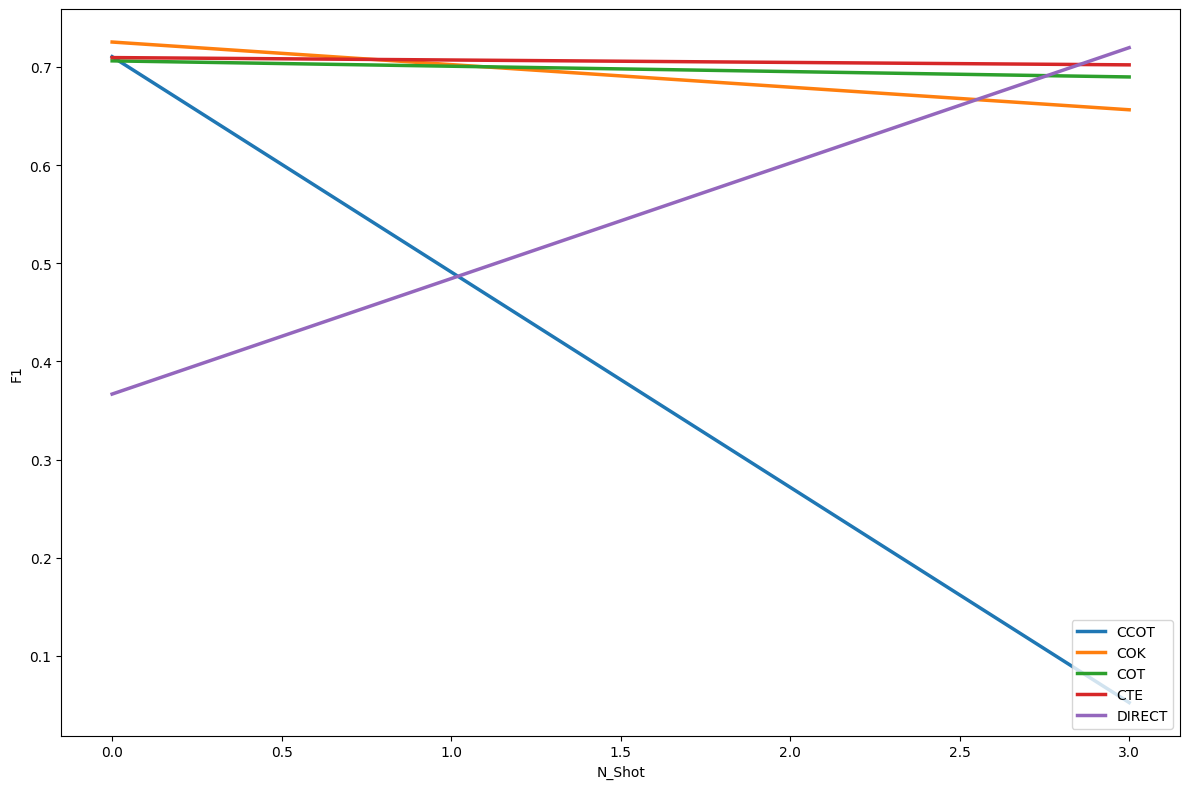

In [52]:
plot_variance(prepared_df[prepared_df['temperature'] < 1.0], x='n_shot', hue='technique', figsize=(12, 8), legend_loc='lower right')

In [53]:
df

,name,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.n_sc,params.run,metrics.exact_match,metrics.f1,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
0,adust-paws,0,ccot/format-thought,cq,semi/ccot,0,1,1,0.591643,0.710493,...,162,700,49.575714,17.156312,19,38.00,47,59.0,187,CCOT
1,lairy-weka,0,ccot/format-thought,cq,semi/ccot,3,1,1,0.036409,0.052465,...,103,2292,16.564136,191.058127,0,0.00,0,4.0,5120,CCOT
2,gypsy-feel,0,cok/adapted,cq,semi/cok,0,1,1,0.612329,0.725410,...,243,674,102.606825,35.052430,24,78.00,97,118.0,300,COK
3,riant-duad,0,cok/adapted,cq,semi/cok,3,1,1,0.547373,0.656394,...,161,863,82.475087,23.488537,3,67.00,81,96.5,168,COK
4,laigh-flex,0,cot/format-thought,cq,semi/cot,0,1,1,0.584195,0.706219,...,211,712,65.831461,92.391326,16,46.75,58,72.0,2444,COT
5,lowly-mesh,0,cot/format-thought,cq,semi/cot,3,1,1,0.573024,0.689830,...,162,768,61.272135,21.961152,6,46.00,58,72.0,140,COT
6,added-kana,0,cte/format-triplets-few,cq,semi/cte,0,1,1,0.590401,0.709570,...,177,697,45.964132,23.595919,7,33.00,43,56.0,263,CTE
7,model-wire,0,cte/format-triplets-few,cq,semi/cte,3,1,1,0.582954,0.702151,...,91,746,48.310992,16.961933,16,37.00,45,56.0,153,CTE
8,rusty-eric,0,direct/format-few,cq,semi/direct,0,1,1,0.291684,0.366754,...,105,1560,50.284615,44.330988,3,22.00,43,65.0,878,DIRECT
9,heady-yews,0,direct/format-few,cq,semi/direct,3,1,1,0.603227,0.719669,...,26,690,7.726087,9.269645,3,4.00,5,7.0,89,DIRECT


In [54]:
mask = (df['params.run'] == 2) & (df['params.qa.temperature'] == 0.1)
df.loc[mask].sort_values('metrics.f1', ascending=False)

,name,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.n_shot,params.qa.n_sc,params.run,metrics.exact_match,metrics.f1,...,metrics.gen_token_count.success.max,metrics.gen_token_count.fail.count,metrics.gen_token_count.fail.mean,metrics.gen_token_count.fail.std,metrics.gen_token_count.fail.min,metrics.gen_token_count.fail.25%,metrics.gen_token_count.fail.50%,metrics.gen_token_count.fail.75%,metrics.gen_token_count.fail.max,params.qa.technique
